In [1]:
# Data Processing
import pandas as pd
from PIL import Image
from examples.generator import generate_dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

# LTN
from nltk.sem.logic import Expression
from ltn_imp.fuzzy_operators.aggregators import SatAgg
from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data Processing

In [2]:
data = pd.DataFrame(generate_dataset(100))

In [3]:
image_paths = [item for item in data[0]]
images = []
for path in image_paths:
    try:
        img = Image.open(path).convert('RGB')  # Convert to RGB to ensure consistency
        img = np.array(img)
        img_tensor = torch.tensor(img, dtype=torch.float32)  # Convert to PyTorch tensor
        images.append(img_tensor)
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        
labels = torch.tensor(data[1])

In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, labels):
        # Convert the list of images to a tensor and permute dimensions to [batch_size, channels, height, width]
        self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
        self.labels = torch.tensor(labels).float()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        return image, label
    
batch_size = 25

# Split the data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(images,labels, test_size=0.2, random_state=42)

# Create the training dataset
train_dataset = ImageDataset(train_data, train_labels)

# Create the test dataset
test_dataset = ImageDataset(test_data, test_labels)

# Create the training dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create the test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        

/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_11961/3823677747.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.images = torch.stack([torch.tensor(image).permute(2, 0, 1) for image in images])
/var/folders/mv/_dg3pqgn2zdf7f95_1dg07rw0000gn/T/ipykernel_11961/3823677747.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels).float()


In [5]:
labels

tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 

In [6]:
print(f"Number of training images: {len(train_data)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of test images: {len(test_data)}")
print(f"Number of test labels: {len(test_labels)}")

Number of training images: 80
Number of training labels: 80
Number of test images: 20
Number of test labels: 20


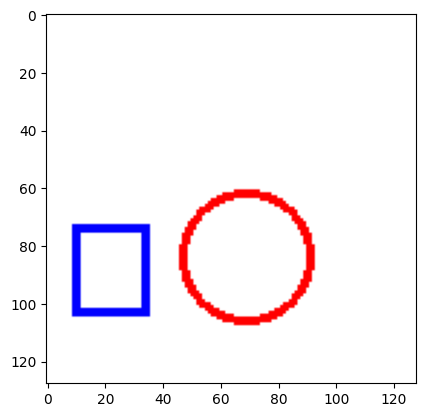

In [7]:
plt.imshow(train_data[0].numpy().astype(np.uint8))

## Models

In [8]:
class CircleDetector(torch.nn.Module):
    def __init__(self):
        super(CircleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)  # Adjusted in_features to 16384
        self.fc2 = nn.Linear(in_features=128, out_features=2)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        c,r = x[:,0], x[:,1]
        return c,r

In [9]:
class RectangleDetector(torch.nn.Module):
    def __init__(self):
        super(RectangleDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=64*16*16, out_features=128)  # Adjusted in_features to 16384
        self.fc2 = nn.Linear(in_features=128, out_features=2)  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        t1,b1 = x[:,0], x[:,1]
        return t1,b1

## Rules

In [10]:
class BoundingBox(nn.Module):
    def __init__(self):
        super(BoundingBox, self).__init__()

    def forward(self, c, r, t1=None, b1=None):
        if t1 is None and b1 is None:
            t1 = c - r / 2
            b1 = c + r / 2
            return t1, b1
        else:
            t1_check = torch.isclose(t1, (c - r / 2), atol=1e-6)
            b1_check = torch.isclose(b1, (c + r / 2), atol=1e-6)
            return torch.logical_and(t1_check, b1_check).float()
        
    def __call__(self, *args):
        return self.forward(*args)

class Inside(nn.Module):
    def __init__(self):
        super(Inside, self).__init__()

    def forward(self, t1, b1, t2, b2):
        return torch.logical_and(torch.lt(t1, t2), torch.lt(b1, b2)).float()

    def __call__(self, *args):
        return self.forward(*args)
    
class Outside(nn.Module):
    def __init__(self):
        super(Outside, self).__init__()

    def forward(self, t1, b1, t2, b2):
        return torch.logical_and(torch.gt(t1, t2), torch.gt(b1, b2)).float()

    def __call__(self, *args):
        return self.forward(*args)
    
class Intersect(nn.Module):
    def __init__(self):
        super(Intersect, self).__init__()

    def forward(self, t1, b1, t2, b2):
        inside = torch.logical_and(torch.lt(t1, t2), torch.lt(b1, b2))
        outside = torch.logical_and(torch.gt(t1, t2), torch.gt(b1, b2))
        return torch.logical_not(torch.logical_or(inside, outside)).float()

    def __call__(self, *args):
        return self.forward(*args)

In [11]:

ancillary_rules = [
]

learning_rules = [
    "all i. ( Circle(i, c, r) and (add(c,r)) )",

]

## Training

In [12]:
from ltn_imp.parsing.parser import LTNConverter

In [13]:
circle = CircleDetector()
rect = RectangleDetector()

In [14]:
data, label = next(iter(train_dataloader))

In [15]:
sat_agg = SatAgg()
optimizer = torch.optim.Adam(list(circle.parameters()) + list(rect.parameters()), lr=0.001)

converter = LTNConverter(predicates={"Circle":circle, "Rect":rect, "bounding_box":BoundingBox(),
                                      "inside": Inside(), "outside": Outside(), "intersect": Intersect()}, quantifier_impls={"forall" : "pmean_error"})

rules = [ converter(rule, process=False) for rule in learning_rules]
log_steps = 2

tensor(0.9783, grad_fn=<RsubBackward1>)
{'c': tensor([-1.6638, -0.9791, -1.6009, -2.4886, -3.9752, -1.8565, -1.8775, -2.9030,
        -2.9972, -3.3154, -2.7618, -2.9688, -1.7157, -1.5277, -1.9881, -1.6676,
        -1.7167, -3.5581, -1.8365, -3.6227, -3.5404, -3.1457, -2.1812, -2.4269,
        -3.3765], grad_fn=<SelectBackward0>), 'r': tensor([5.3908, 7.7147, 6.2517, 5.2640, 4.8753, 6.6550, 5.5788, 6.3874, 5.7139,
        5.1655, 5.4806, 5.8545, 5.9719, 6.4815, 5.5253, 5.9648, 6.2612, 5.3808,
        6.7297, 4.5799, 5.5853, 6.0421, 4.3272, 4.7905, 4.6156],
       grad_fn=<SelectBackward0>)}


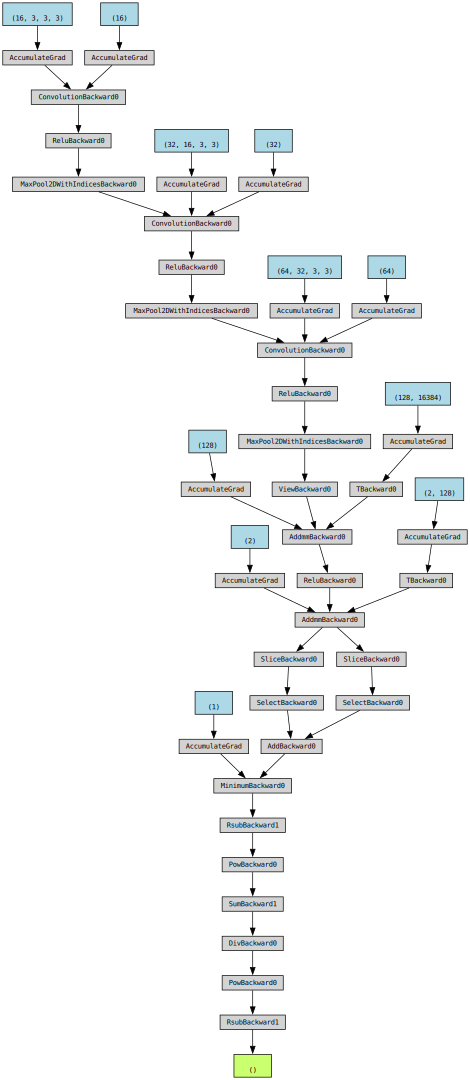

In [16]:
var_mapping = {"i" : data, "y": label, "in" : torch.tensor([1.,0.,0.]), "out": torch.tensor([0.,0.,1.]), "int": torch.tensor([0.,1.,0.])}
print(rules[0](var_mapping))
print(converter.declarations)
rules[0].comp_graph(var_mapping)